## Qiskit Quantum Reservoir Tutorial

[Ref] Yasuda, T., Suzuki, Y., Kubota, T., Nakajima, K., Gao, Q., Zhang, W., ... & Yamamoto, N. (2023). Quantum reservoir computing with repeated measurements on superconducting devices. arXiv preprint arXiv:2310.06706.


This tutorial walks through a simplified implementation of the "Quantum Reservoir Computing with Repeated Measurements" paper, demonstrating how to predict a time-series task using a simulated quantum reservoir in Qiskit.


First, set up a backend. To run circuits on a real quantum computer, we first connect to the IBM Quantum service using `QiskitRuntimeService`. Then, from the available backends, we select the specific hardware we can use for this experiment.

This tutorial uses 10s QPU time.

In [6]:
# Save your API token to track your progress and have access to the quantum computers
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator

#your_token="your_token"
#your_instace="your_crn"


#QiskitRuntimeService.save_account(
#    channel="ibm_cloud",
#    token=your_token,
#    instance=your_instace,
#    set_as_default=True,
#    overwrite=True,
#)

service = QiskitRuntimeService()

real_backend = service.least_busy(operational=True, simulator=False)
backend = AerSimulator()

real_backend

<IBMBackend('ibm_torino')>

## 1. Data Generation: The NARMA2 Task

First, we generate the dataset for the Nonlinear Autoregressive Moving Average (NARMA2) task.

1. The input signal $u(t)$ is a deterministic time-series created by multiplying three sine waves, as specified in the paper.

2. The target signal $y(t)$ is generated from the input u(t) and its own past values, following the NARMA2 equation

$$y(t+1) = 0.4*y(t) + 0.4*y(t)*y(t-1) + 0.6*u(t)² + 0.1$$

This creates a complex, nonlinear relationship that the quantum reservoir will try to learn.

## 2. Quantum Reservoir Implementation

The core of this tutorial is the quantum circuit, designed to mimic the paper's proposed architecture.

Repeated Measurement Scheme: We use a dynamic circuit that processes the entire time series in a single run. This is the main contribution of the paper, as it avoids the costly process of re-initializing the circuit for each timestep.


### Circuit Structure:

- System Qubits: A 2-qubit system that encodes the input signal u(t) into the rotation angles of RX and RZ gates.
- Ancilla Qubits: A 2-qubit system that interacts with the system qubits before being measured and reset at each timestep.
- Output: The expectation values of the ancilla qubits form the "reservoir states," which are the features used for training.

## 3. Training and Prediction
The final step is classical. We train a simple linear model to interpret the outputs from our quantum reservoir.
- Washout Period: We discard the first 20 timesteps of the reservoir's output to allow its dynamics to synchronize with the input signal.
- Linear Regression: The reservoir's output states are mapped to the target signal y(t) by finding an optimal weight matrix w_out using a standard pseudo-inverse method.
- Prediction: The trained model is then used to predict the target signal for the entire time series. The plot shows how well the model's predictions (green dots for training, red crosses for testing) match the true target signal (blue line).

## 4. Limitations and Differences from the Paper

This tutorial provides a functional demonstration, but it differs from the full research paper in several critical ways:
- Hardware vs. Simulation: This code runs on a noiseless classical simulator (AerSimulator). The paper's experiments were conducted on real, noisy superconducting hardware (ibmq_toronto). The presence of real quantum noise can significantly alter the reservoir's dynamics and is sometimes considered a useful computational resource.
- Reservoir Size: We use a minimal 2-qubit system. This has very limited computational capacity. The paper's results are based on a larger system, and it even presents a preliminary study with a 120-qubit device, suggesting that scale is crucial for performance.
- Untuned Hyperparameters: The success of this model is highly sensitive to hyperparameters like the input scaling factor and the system-ancilla interaction strength. This tutorial uses fixed values, whereas the paper implies a tuning process to find optimal parameters. The learning performance here is not optimize

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister, Parameter

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, Batch, SamplerV2 as Sampler

# =============================================================================
# STEP 1: DEFINE DATA GENERATION AND QRC FUNCTIONS
# =============================================================================
backend=real_backend


def generate_narma2_data(L, T=100):
    """Generates random input u and target y for the NARMA2 task."""
    timesteps = np.arange(L)
    alpha_bar, beta_bar, gamma_bar = 2.11, 3.73, 4.11 
    u = 0.1 * (np.sin(2 * np.pi * alpha_bar * timesteps / T) *
               np.sin(2 * np.pi * beta_bar * timesteps / T) *
               np.sin(2 * np.pi * gamma_bar * timesteps / T) + 1)

    # 2. generate y(t)
    y = np.zeros(L)
    if L > 1:
        y[0] = 0.1
        y[1] = 0.1
    for t in range(1, L - 1):
        y[t+1] = 0.4 * y[t] + 0.4 * y[t] * y[t-1] + 0.6 * u[t]**2 + 0.1
    return u, y

def create_qrc_timestep(input_param):
    """Creates a single QRC timestep circuit."""
    system_q = QuantumRegister(2, name='system')
    ancilla_q = QuantumRegister(2, name='ancilla')
    cr = ClassicalRegister(2, name='c')
    qc = QuantumCircuit(system_q, ancilla_q, cr)
    qc.rx(input_param, system_q[0])
    qc.cx(system_q[0], system_q[1])
    qc.rx(input_param, system_q[0])
    qc.rz(input_param, system_q[1])
    qc.cx(system_q[0], system_q[1])
    qc.barrier()
    qc.cx(system_q[0], ancilla_q[0])
    qc.cx(system_q[1], ancilla_q[1])
    qc.barrier()
    qc.measure(ancilla_q, cr)
    qc.reset(ancilla_q)
    qc.barrier()
    return qc


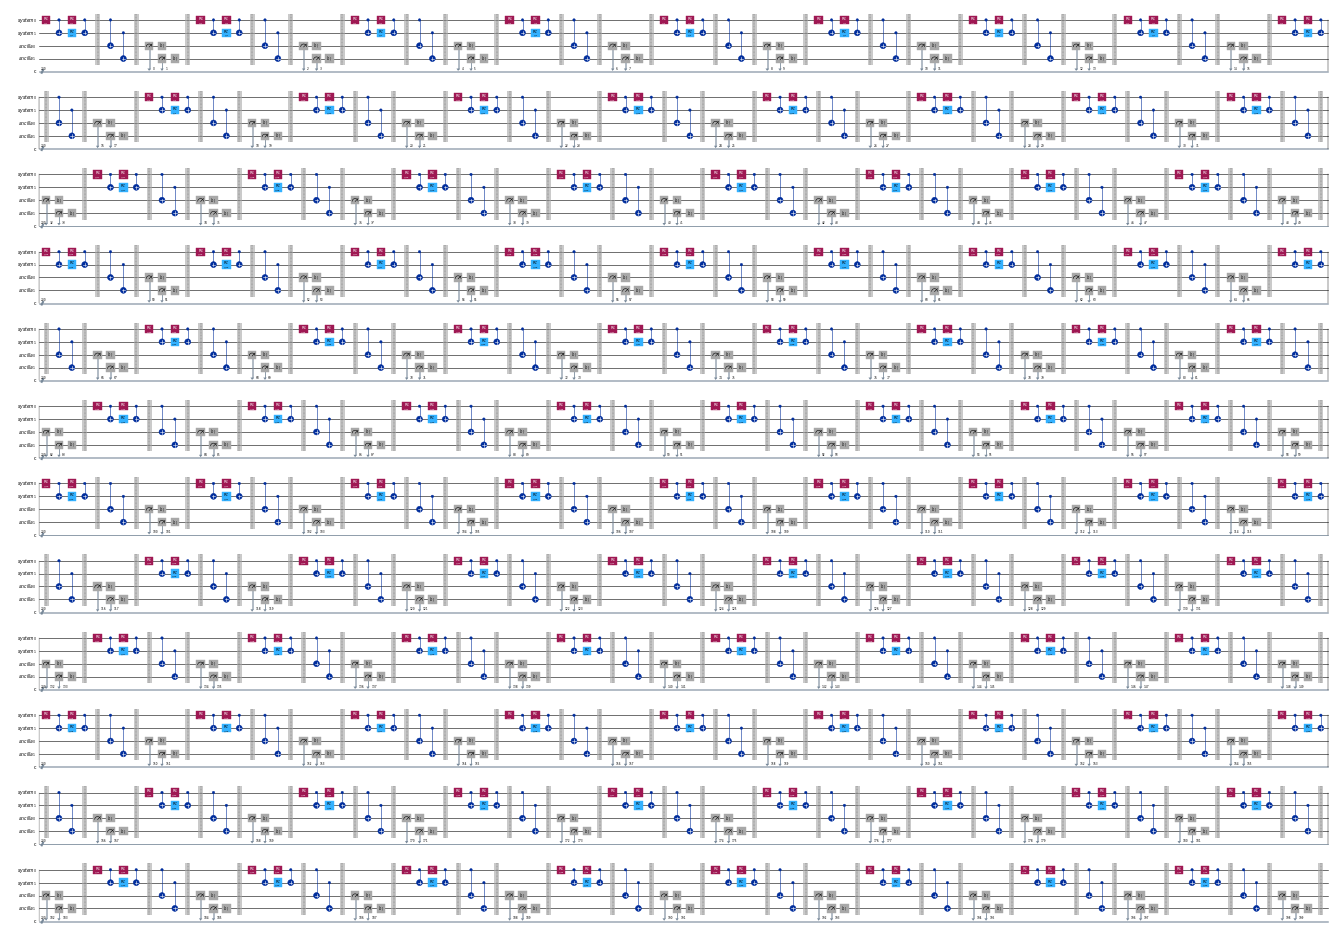

In [3]:
# =============================================================================
# STEP 2: GENERATE DATA AND RUN QRC SIMULATION
# =============================================================================
L = 100
shots = 8192

input_values, y_target = generate_narma2_data(L)

# Build the full dynamic circuit
input_params = [Parameter(f'u_{t}') for t in range(L)]
system_q = QuantumRegister(2, name='system')
ancilla_q = QuantumRegister(2, name='ancilla')
cr = ClassicalRegister(L * 2, name='c')
full_qrc_circuit = QuantumCircuit(system_q, ancilla_q, cr)


for t in range(L):
    timestep_qc = create_qrc_timestep(input_params[t])
    full_qrc_circuit.compose(
        timestep_qc,
        qubits=system_q[:] + ancilla_q[:],
        clbits=cr[2*t : 2*(t+1)],
        inplace=True
    )

display(full_qrc_circuit.draw('mpl', scale=0.2, fold=100))

# Run simulation
param_dict = {param: value for param, value in zip(input_params, input_values)}

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

qc_tr=pm.run(full_qrc_circuit)

sampler = Sampler(mode=backend)


# --- FIX IS HERE ---
# The line `bound_circuit = transpiled_circuit.bind_parameters(param_dict)` is removed.
# Instead, the parameter dictionary is passed directly into the `run` method.

# [cite_start]Run the simulation (the paper uses 8192 shots) [cite: 124]
shots = 8192
result = sampler.run(
    [(qc_tr,
    param_dict)], # Pass the dictionary in a list
    shots=shots
).result()
counts = result[0].data.c.get_counts()

# Process results to get reservoir states
reservoir_states = np.zeros((L, 2))
for t in range(L):
    counts_t = {}
    for bitstring, count in counts.items():
        reversed_bitstring = bitstring[::-1]
        timestep_bits = reversed_bitstring[2*t : 2*(t+1)]
        counts_t[timestep_bits] = counts_t.get(timestep_bits, 0) + count
    for i in range(2):
        p0 = sum(v for k, v in counts_t.items() if k[i] == '0') / shots
        p1 = sum(v for k, v in counts_t.items() if k[i] == '1') / shots
        reservoir_states[t, i] = p0 - p1



In [4]:
# =============================================================================
# STEP 3: TRAIN THE MODEL (with washout)
# =============================================================================
washout = 10
split_point = 80
train_start = washout
train_end = split_point

X_train = np.hstack([reservoir_states[train_start:train_end], np.ones((train_end - train_start, 1))])
y_train = y_target[train_start:train_end]

w_out = np.linalg.pinv(X_train).dot(y_train)

X_full = np.hstack([reservoir_states[washout:], np.ones((L - washout, 1))])
y_pred = X_full @ w_out



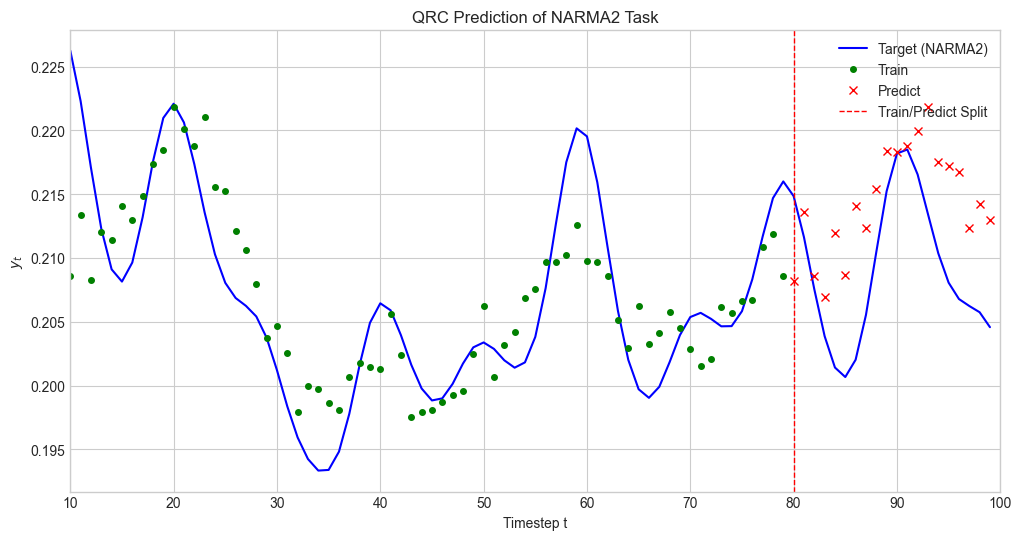

In [5]:
# =============================================================================
# STEP 4: PLOT THE RESULTS
# =============================================================================
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 6))

plot_timesteps = range(washout, L)
ax.plot(plot_timesteps, y_target[washout:], 'b-', label='Target (NARMA2)')
ax.plot(plot_timesteps[:split_point-washout], y_pred[:split_point-washout], 'go', markersize=4, label='Train')
ax.plot(plot_timesteps[split_point-washout:], y_pred[split_point-washout:], 'rx', markersize=6, label='Predict')
ax.axvline(x=split_point, color='r', linestyle='--', linewidth=1, label='Train/Predict Split')

ax.set_title('QRC Prediction of NARMA2 Task')
ax.set_xlabel('Timestep t')
ax.set_ylabel('$y_t$')
ax.legend(loc='upper right')
ax.set_xlim(washout, L)
plt.show()